In [1]:
# Import packages and settings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px

import os, sys
dir1 = os.path.dirname(os.path.abspath(''))
if not dir1 in sys.path: sys.path.append(dir1)
import preprocessing.data_format as data_format
import preprocessing.data_cleaning as data_cleaning
import preprocessing.data_imputation as data_imputation
import plotly.graph_objects as go
from IPython.display import display
pd.options.mode.chained_assignment = None
plt.rcParams["figure.figsize"] = (15,5)

In [31]:
dt_resolution = dt.timedelta(minutes=60)
dt_start = dt.datetime(day=1, month=1, year=2004)
dt_end = dt.datetime(day=7, month=7, year=2008) #exclusive last day
dt_ref = pd.date_range(start=dt_start, end=dt_end, freq=str(dt_resolution.seconds) + "S", inclusive="left")

utilities = ["Load_history", "Load_solution", "temperature_history", "temperature_solution"]
site_id = "GFC12_load"
base_url = f'../data/{site_id}'
timestamp_format = "%Y-%m-%d-%H"

data = {}
for utility in utilities:
    # Read data
    data[utility] = pd.read_csv(f'{base_url}/{utility}.csv', thousands=",")
    columns = data[utility].columns
    
    # Handle hour columns from load excel files
    if "hour" not in columns:
        non_hour_columns = [col for col in columns if not col.startswith("h")]
        data[utility] = pd.melt(data[utility], id_vars=non_hour_columns, var_name="hour")
        data[utility]["hour"] = data[utility]["hour"].str.strip("h").astype(int)
        
    # Convert to hour format [0, 23]
    data[utility]["hour"] = data[utility]["hour"].sub(1)
    
    # Delete excess columns
    for col in columns:
        if col in ["id", "weight", "datetime", "date"]:
            data[utility] = data[utility].drop(columns=col)
            
    # Join datetime columns into one
    datetime_names = ['year', 'month', 'day', 'hour']
    data[utility]["datetime"] = data[utility][datetime_names].astype(str).apply(lambda x: x.str.zfill(2)).agg('-'.join, axis=1)
    data[utility]["datetime"] = pd.to_datetime(data[utility]["datetime"], format="%Y-%m-%d-%H")
    data[utility] = data[utility].drop(columns=datetime_names)
    
    # Set index
    if utility.startswith("Load"):
        data[utility] = data[utility].set_index(["datetime", "zone_id"])
    else:
        data[utility] = data[utility].set_index(["datetime", "station_id"])

In [32]:
# Fill values with solution and construct data format with zone per column
end_date_slice = pd.IndexSlice[:"2008-06-30 05:00:00", :]
data["load"] = data["Load_history"].fillna(data["Load_solution"]).sort_index().reset_index().pivot(index='datetime', columns='zone_id', values='value').loc[end_date_slice]
data["airTemperature"] = data["temperature_history"].fillna(data["temperature_solution"]).sort_index().reset_index().pivot(index='datetime', columns='station_id', values='value').loc[end_date_slice]
del data["Load_history"], data["Load_solution"], data["temperature_history"], data["temperature_solution"]

# Concatenate dataframes
data = pd.concat(data, axis=1)

# Set resolution
data.index.freq = f"{dt_resolution.seconds}S"

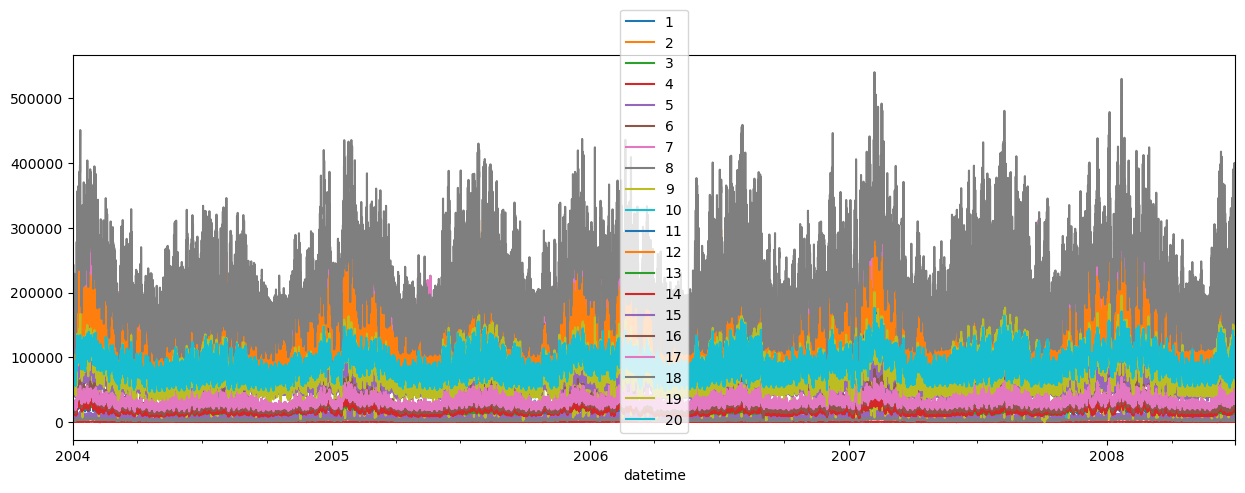

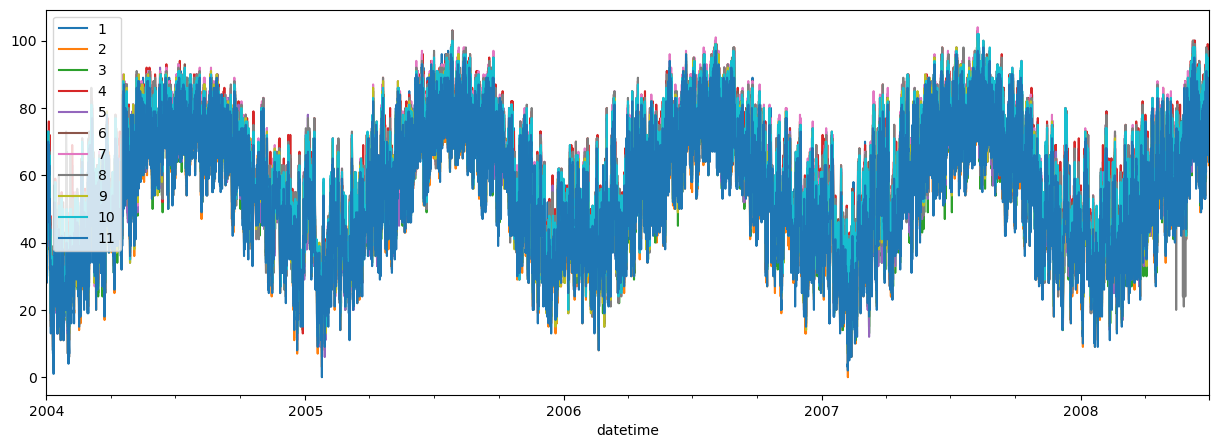

In [34]:
# Plot data
for col in ["load", "airTemperature"]:
    data[col].plot()
    plt.show()

In [ ]:
# Reformat dataframe
data = pd.concat(data, axis=1).swaplevel(axis=1).sort_index(axis=1)

# Save dataframe
save_flag = True
nans = data.isna().sum().sum()
if nans==0 and save_flag:
    data.to_pickle(f"{base_url}/load_with_weather.pkl")
    print("Saved!")